In [1]:
import os
import json
import math

import numpy as np
import torch
from PIL import Image

RAW_ROOT = "/data1_ycao/chua/projects/cdTeacher/data_raw/c1_descending_t2_v2"
OUT_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2"

os.makedirs(OUT_ROOT, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# 来自你之前的相机内参
omni_intrinsics = {
    "width": 1350,
    "height": 1080,
    "cx": 677.739464094188,
    "cy": 543.057997844875,
    "a0": 767.733695862103,
    "a1": 0.0,
    "a2": -0.000592506426558248,
    "a3": -2.69440266600040e-07,
    "a4": -2.16380341010063e-10,
    "c": 0.9999,
    "d": 1.10e-4,
    "e": -1.83e-4,
}

with open(os.path.join(OUT_ROOT, "camera_omni.json"), "w") as f:
    json.dump(omni_intrinsics, f, indent=2)
print("Saved omni intrinsics to camera_omni.json")


Saved omni intrinsics to camera_omni.json


In [3]:
class OmniCamera(torch.nn.Module):
    """
    Scaramuzza-style omnidirectional camera (pixel -> ray in camera frame).
    坐标系约定:
      - 像素: u 向右, v 向下
      - 相机系: +x 向右, +y 向下, +z 沿视线方向
    """
    def __init__(self, intrinsics):
        super().__init__()
        self.width = intrinsics["width"]
        self.height = intrinsics["height"]
        self.cx = intrinsics["cx"]
        self.cy = intrinsics["cy"]
        self.c = intrinsics["c"]
        self.d = intrinsics["d"]
        self.e = intrinsics["e"]
        # 多项式系数 pol(r) = a0 + a1*r + ... (cam2world 用)
        self.register_buffer(
            "pol",
            torch.tensor([
                intrinsics["a0"],
                intrinsics["a1"],
                intrinsics["a2"],
                intrinsics["a3"],
                intrinsics["a4"],
            ], dtype=torch.float32),
        )

        # 预算 affine 矩阵的逆: [x';y'] = A^{-1} * ([u-cx; v-cy])
        A = torch.tensor([[self.c, self.d],
                          [self.e, 1.0]], dtype=torch.float32)
        A_inv = torch.inverse(A)
        self.register_buffer("A_inv", A_inv)

    def forward(self, u, v):
        """
        u, v: (...,) 像素坐标 (float32)，可以是任意 shape
        返回: (..., 3) 单位方向向量 (x,y,z) in camera frame
        """
        # 保证 tensor
        u = torch.as_tensor(u, dtype=torch.float32, device=self.pol.device)
        v = torch.as_tensor(v, dtype=torch.float32, device=self.pol.device)

        # 平移到主点
        x_img = u - self.cx
        y_img = v - self.cy

        # 逆 affine 校正
        # [x'; y'] = A_inv @ [x_img; y_img]
        x_prime = self.A_inv[0, 0] * x_img + self.A_inv[0, 1] * y_img
        y_prime = self.A_inv[1, 0] * x_img + self.A_inv[1, 1] * y_img

        r = torch.sqrt(x_prime**2 + y_prime**2)  # 半径

        # 计算 z = pol(r)
        # pol(r) = a0 + a1*r + a2*r^2 + ...
        # 用 Horner 法或直接 sum
        powers = torch.stack([r**i for i in range(self.pol.shape[0])], dim=0)  # (deg+1, ...)
        z = (self.pol.view(-1, *([1] * (powers.ndim - 1))) * powers).sum(dim=0)

        # 方向向量 (x', y', z)，再单位化
        # 注意: 如果 r=0，则 x'=y'=0，此时方向就是 (0,0,1)
        dir_cam = torch.stack([x_prime, y_prime, z], dim=-1)
        dir_norm = dir_cam / torch.linalg.norm(dir_cam, dim=-1, keepdim=True).clamp(min=1e-9)
        return dir_norm

omni_cam = OmniCamera(omni_intrinsics).to(device)
print("Omni camera model ready.")


Omni camera model ready.


In [8]:
pose_path = os.path.join(RAW_ROOT, "pose.txt")
poses_list = []

with open(pose_path, "r") as f:
    for line_idx, line in enumerate(f):
        line = line.strip()
        if not line:
            continue

        # 支持逗号和空格：把逗号先替换成空格，再 split
        parts = [p for p in line.replace(",", " ").split() if p]
        if len(parts) != 16:
            raise ValueError(
                f"Line {line_idx} in pose.txt has {len(parts)} values, expected 16. Line content: {line}"
            )

        vals = np.array(parts, dtype=np.float32)
        mat_raw = vals.reshape(4, 4)      # 这是 T^T 的形状
        T = mat_raw.T                     # 转置成标准 T_cam2world

        # ✅ 把平移从 mm → m，和 depth_m 对齐
        T[0:3, 3] /= 1000.0

        poses_list.append(T)

poses_cam2world = torch.from_numpy(np.stack(poses_list, axis=0))  # (N,4,4)
print("Loaded poses:", poses_cam2world.shape)
print("Pose[0]:\n", poses_cam2world[0])
print("torch norm of translation vector in pose[0]:",
      torch.linalg.norm(poses_cam2world[0, :3, 3]))
norms = torch.linalg.norm(poses_cam2world[:, :3, 3], dim=1)
print("min / max / mean translation norm (m):",
      norms.min().item(), norms.max().item(), norms.mean().item())
R0 = poses_cam2world[0, :3, :3]
print("R0^T R0 ≈\n", (R0.T @ R0))
print("det(R0) =", torch.linalg.det(R0))



Loaded poses: torch.Size([617, 4, 4])
Pose[0]:
 tensor([[ 0.5735, -0.4647,  0.6746, -0.4762],
        [ 0.3601, -0.5975, -0.7177, -0.1685],
        [ 0.7360,  0.6534, -0.1761, -0.3193],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
torch norm of translation vector in pose[0]: tensor(0.5976)
min / max / mean translation norm (m): 0.5902969241142273 0.606565535068512 0.5982859134674072
R0^T R0 ≈
 tensor([[ 1.0003e+00, -7.6939e-04, -1.1406e-03],
        [-7.6939e-04,  9.9982e-01,  2.7472e-04],
        [-1.1406e-03,  2.7472e-04,  1.0012e+00]])
det(R0) = tensor(1.0007)


In [22]:
def load_depth_and_mask(frame_id: int):
    fname = f"{frame_id:04d}"
    depth_path = os.path.join(RAW_ROOT, "depth", f"{fname}_depth.tiff")
    occ_path   = os.path.join(RAW_ROOT, "occlusions", f"{fname}_occlusion.png")

    depth_img = np.array(Image.open(depth_path))  # 原始是 uint16
    occ_img   = np.array(Image.open(occ_path))    # uint8

    # ⚠️ 关键改动：不要用 uint16，改成 int32
    depth_raw = torch.from_numpy(depth_img.astype(np.int32)).to(device)
    occ_u8    = torch.from_numpy(occ_img.astype(np.uint8)).to(device)

    # 0~65535 → 0~0.1 m (0~100mm)
    depth_m = depth_raw.to(torch.float32) / 65535.0 * 0.1

    # 有效像素：有深度 && 没 occlusion
    valid = (depth_raw > 0) & (occ_u8 == 0)

    return depth_m, valid


In [23]:
H = omni_intrinsics["height"]
W = omni_intrinsics["width"]

# 生成像素坐标网格 (H,W)
u_coords = torch.arange(W, device=device).view(1, -1).expand(H, W)  # v 行, u 列
v_coords = torch.arange(H, device=device).view(-1, 1).expand(H, W)

# 预计算像素对应的射线方向（在 Camera Frame）
with torch.no_grad():
    dirs_cam = omni_cam(u_coords, v_coords)  # (H,W,3)
print("dirs_cam shape:", dirs_cam.shape)


dirs_cam shape: torch.Size([1080, 1350, 3])


In [24]:
def frame_points_world(frame_id: int, max_points: int = None):
    """
    返回某一帧的世界系点云 (N,3)
    max_points: 为了控制内存，可以随机 subsample
    """
    depth_m, valid = load_depth_and_mask(frame_id)   # (H,W)
    dirs = dirs_cam  # (H,W,3)

    # 有效像素
    valid_mask = valid & (depth_m > 0)
    if valid_mask.sum() == 0:
        return None

    depth_z = depth_m  # 沿 z 轴的深度

    # 提取有效像素的射线方向和 depth_z
    depth_z_valid = depth_z[valid_mask]  # (Nv,)
    dirs_valid = dirs[valid_mask]        # (Nv,3)

    # 避免除以 0
    dz = dirs_valid[:, 2].clamp(min=1e-6)
    scale = depth_z_valid / dz          # (Nv,)

    pts_cam = dirs_valid * scale.unsqueeze(-1)  # (Nv,3)

    # 取该帧的 pose
    T = poses_cam2world[frame_id].to(device)    # (4,4)
    R = T[:3, :3]
    t = T[:3, 3]

    pts_world = (R @ pts_cam.T + t.view(3, 1)).T  # (Nv,3)

    # 可选 subsample，避免点数太多
    if max_points is not None and pts_world.shape[0] > max_points:
        idx = torch.randperm(pts_world.shape[0], device=device)[:max_points]
        pts_world = pts_world[idx]

    return pts_world


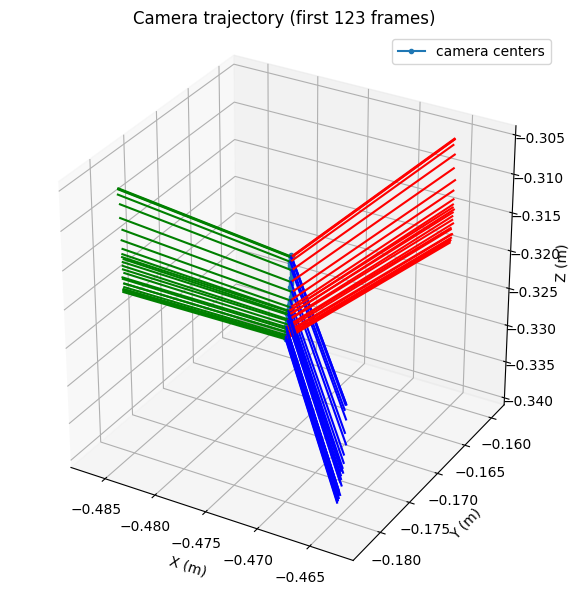

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_camera_trajectory(poses_cam2world, num_frames=10, stride=1):
    """
    简单的相机轨迹可视化工具。
    - poses_cam2world: (N,4,4) torch.Tensor
    """
    # 全部先变成 numpy，避免 torch 和 matplotlib 打架
    poses_np = poses_cam2world.detach().cpu().numpy()  # (N,4,4)
    N = poses_np.shape[0]
    num_frames = min(num_frames, N)

    # 相机中心 C = t
    C = poses_np[:num_frames, :3, 3]  # (num_frames, 3)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    # 轨迹线
    ax.plot(C[:, 0], C[:, 1], C[:, 2], "-o", markersize=3, label="camera centers")

    # 画若干帧的小坐标轴
    axis_len = 0.02  # m
    for i in range(0, num_frames, stride):
        T = poses_np[i]
        R = T[:3, :3]   # (3,3)
        t = T[:3, 3]    # (3,)

        x_axis = t + R[:, 0] * axis_len
        y_axis = t + R[:, 1] * axis_len
        z_axis = t + R[:, 2] * axis_len

        # 这里都用纯 float / list，彻底避免 torch
        ax.plot([t[0], x_axis[0]], [t[1], x_axis[1]], [t[2], x_axis[2]], "r-")
        ax.plot([t[0], y_axis[0]], [t[1], y_axis[1]], [t[2], y_axis[2]], "g-")
        ax.plot([t[0], z_axis[0]], [t[1], z_axis[1]], [t[2], z_axis[2]], "b-")

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"Camera trajectory (first {num_frames} frames)")

    ax.legend()
    ax.set_box_aspect([1, 1, 1])
    plt.tight_layout()
    plt.show()

plot_camera_trajectory(poses_cam2world, num_frames=123, stride=5)



In [26]:
def write_ply(path, points: np.ndarray):
    """
    points: (N,3) float32 numpy array
    """
    N = points.shape[0]
    with open(path, "w") as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("end_header\n")
        for p in points:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")
    print(f"Saved PLY with {N} points to {path}")


In [33]:
all_points = []

num_frames = poses_cam2world.shape[0]
print("Total frames:", num_frames)

# 先用少数 frame 热身，比如前 20 帧
max_frames = min(num_frames, 123)

for fid in range(max_frames):
    pts_w = frame_points_world(fid, max_points=5000)  # 每帧最多 5000 点，避免炸显存
    if pts_w is None:
        continue
    all_points.append(pts_w.cpu())
    print(f"Frame {fid:04d}: {pts_w.shape[0]} pts")

if len(all_points) == 0:
    print("No points collected, check masks / depth.")
else:
    all_points_tensor = torch.cat(all_points, dim=0)  # (N_total,3)
    pts_np = all_points_tensor.numpy().astype(np.float32)
    ply_path = os.path.join(OUT_ROOT, "gt_pointcloud_partial.ply")
    write_ply(ply_path, pts_np)


Total frames: 617
Frame 0000: 5000 pts
Frame 0001: 5000 pts
Frame 0002: 5000 pts
Frame 0003: 5000 pts
Frame 0004: 5000 pts
Frame 0005: 5000 pts
Frame 0006: 5000 pts
Frame 0007: 5000 pts
Frame 0008: 5000 pts
Frame 0009: 5000 pts
Frame 0010: 5000 pts
Frame 0011: 5000 pts
Frame 0012: 5000 pts
Frame 0013: 5000 pts
Frame 0014: 5000 pts
Frame 0015: 5000 pts
Frame 0016: 5000 pts
Frame 0017: 5000 pts
Frame 0018: 5000 pts
Frame 0019: 5000 pts
Frame 0020: 5000 pts
Frame 0021: 5000 pts
Frame 0022: 5000 pts
Frame 0023: 5000 pts
Frame 0024: 5000 pts
Frame 0025: 5000 pts
Frame 0026: 5000 pts
Frame 0027: 5000 pts
Frame 0028: 5000 pts
Frame 0029: 5000 pts
Frame 0030: 5000 pts
Frame 0031: 5000 pts
Frame 0032: 5000 pts
Frame 0033: 5000 pts
Frame 0034: 5000 pts
Frame 0035: 5000 pts
Frame 0036: 5000 pts
Frame 0037: 5000 pts
Frame 0038: 5000 pts
Frame 0039: 5000 pts
Frame 0040: 5000 pts
Frame 0041: 5000 pts
Frame 0042: 5000 pts
Frame 0043: 5000 pts
Frame 0044: 5000 pts
Frame 0045: 5000 pts
Frame 0046: 5000

In [34]:
import open3d as o3d
import numpy as np
import os

ply_path = os.path.join(OUT_ROOT, "gt_pointcloud_partial.ply")

pcd = o3d.io.read_point_cloud(ply_path)
print(pcd)
print("Point count:", np.asarray(pcd.points).shape[0])



PointCloud with 615000 points.
Point count: 615000


Loaded points: (615000, 3)


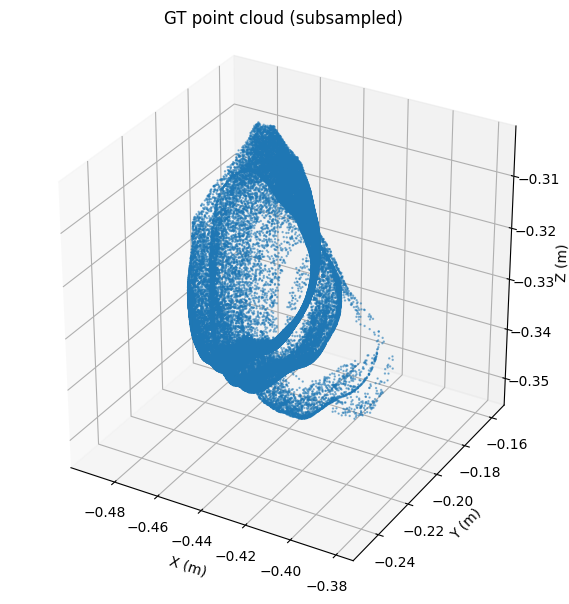

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

pts = np.asarray(pcd.points)
print("Loaded points:", pts.shape)

# 随机下采样一点，避免点太多渲染太慢
max_points = 60000
if pts.shape[0] > max_points:
    idx = np.random.choice(pts.shape[0], max_points, replace=False)
    pts_vis = pts[idx]
else:
    pts_vis = pts

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(pts_vis[:, 0], pts_vis[:, 1], pts_vis[:, 2], s=0.5, alpha=0.5)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("GT point cloud (subsampled)")

ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()


following code description

定义虚拟 pinhole 相机（分辨率 + FOV + fx/fy/cx/cy）

用 fisheye 像素 → 射线 → pinhole 像素 做 forward splat 重采样

导出 undistorted RGB 

生成 Nerfstudio 兼容的 transforms.json 

In [37]:
import math
import json
import os
from tqdm import tqdm
import torch
import numpy as np
from PIL import Image

# 原始 fisheye 分辨率
H_f = omni_intrinsics["height"]
W_f = omni_intrinsics["width"]

# 目标 pinhole 分辨率（可改）
W_p = 960
H_p = 720

# 目标 pinhole FOV（水平）
fov_deg = 90.0
fov_rad = math.radians(fov_deg)

# fx = (W/2) / tan(FOV/2)
fx = (W_p / 2.0) / math.tan(fov_rad / 2.0)
fy = fx  # 保持方像素

cx_p = W_p / 2.0
cy_p = H_p / 2.0

pinhole_intrinsics = {
    "width": W_p,
    "height": H_p,
    "fx": fx,
    "fy": fy,
    "cx": cx_p,
    "cy": cy_p,
    "fov_deg": fov_deg,
}

print("Pinhole intrinsics:", pinhole_intrinsics)

# 输出目录
UNDIST_ROOT = os.path.join(OUT_ROOT, "undistorted")
UNDIST_RGB_ROOT = os.path.join(UNDIST_ROOT, "rgb")
os.makedirs(UNDIST_RGB_ROOT, exist_ok=True)

with open(os.path.join(UNDIST_ROOT, "camera_pinhole.json"), "w") as f:
    json.dump(pinhole_intrinsics, f, indent=2)


Pinhole intrinsics: {'width': 960, 'height': 720, 'fx': 480.00000000000006, 'fy': 480.00000000000006, 'cx': 480.0, 'cy': 360.0, 'fov_deg': 90.0}


In [38]:
H = omni_intrinsics["height"]
W = omni_intrinsics["width"]

u_coords = torch.arange(W, device=device).view(1, -1).expand(H, W)
v_coords = torch.arange(H, device=device).view(-1, 1).expand(H, W)

with torch.no_grad():
    dirs_cam = omni_cam(u_coords, v_coords)  # (H,W,3)
print("dirs_cam:", dirs_cam.shape)


dirs_cam: torch.Size([1080, 1350, 3])


In [39]:
# dirs_cam: (H_f, W_f, 3)
x_f = dirs_cam[..., 0]  # (H_f, W_f)
y_f = dirs_cam[..., 1]
z_f = dirs_cam[..., 2].clamp(min=1e-6)  # 避免除以 0

# 对每个 fisheye 像素，计算它投到 pinhole 上的位置
u_p_map = fx * (x_f / z_f) + cx_p
v_p_map = fy * (y_f / z_f) + cy_p

print("u_p_map range:", u_p_map.min().item(), u_p_map.max().item())
print("v_p_map range:", v_p_map.min().item(), v_p_map.max().item())


u_p_map range: -14962.5498046875 10463.9384765625
v_p_map range: -12016.4609375 8674.453125


In [40]:
def fisheye_to_pinhole_rgb(rgb_fisheye: torch.Tensor,
                           u_p_map: torch.Tensor,
                           v_p_map: torch.Tensor,
                           W_p: int,
                           H_p: int):
    """
    rgb_fisheye: (H_f, W_f, 3), float32, [0,1]
    u_p_map, v_p_map: (H_f, W_f), 每个 fisheye 像素在 pinhole 平面上的浮点坐标
    返回:
      rgb_pinhole: (H_p, W_p, 3), float32, [0,1]
      weight: (H_p, W_p), float32, 每个像素累计权重（用于 Debug）
    """
    device = rgb_fisheye.device
    H_f, W_f, _ = rgb_fisheye.shape

    # 展平成一维，方便 scatter
    u_flat = u_p_map.reshape(-1)
    v_flat = v_p_map.reshape(-1)
    rgb_flat = rgb_fisheye.reshape(-1, 3)

    # 只保留 z>0 且投影落在 pinhole 范围附近的点（多给 1 像素边界）
    valid = (
        (u_flat >= -1) & (u_flat <= W_p) &
        (v_flat >= -1) & (v_flat <= H_p)
    )
    u_flat = u_flat[valid]
    v_flat = v_flat[valid]
    rgb_flat = rgb_flat[valid]

    # 计算周围的四个像素
    u0 = torch.floor(u_flat).to(torch.long)
    v0 = torch.floor(v_flat).to(torch.long)
    du = u_flat - u0.to(torch.float32)
    dv = v_flat - v0.to(torch.float32)

    # 四个角： (u0,v0), (u0+1,v0), (u0,v0+1), (u0+1,v0+1)
    u1 = u0 + 1
    v1 = v0 + 1

    # 权重
    w00 = (1 - du) * (1 - dv)
    w10 = du * (1 - dv)
    w01 = (1 - du) * dv
    w11 = du * dv

    # 初始化输出
    rgb_out = torch.zeros((H_p, W_p, 3), dtype=torch.float32, device=device)
    w_out = torch.zeros((H_p, W_p), dtype=torch.float32, device=device)

    def accumulate(u, v, w):
        # 过滤在图像范围内的
        mask = (u >= 0) & (u < W_p) & (v >= 0) & (v < H_p) & (w > 0)
        if mask.sum() == 0:
            return
        u_sel = u[mask]
        v_sel = v[mask]
        w_sel = w[mask]
        rgb_sel = rgb_flat[mask]

        idx = v_sel * W_p + u_sel  # flatten 索引

        # 对 RGB 进行 scatter_add
        rgb_out_flat = rgb_out.reshape(-1, 3)
        w_out_flat = w_out.reshape(-1)

        rgb_out_flat.index_add_(0, idx, rgb_sel * w_sel.unsqueeze(-1))
        w_out_flat.index_add_(0, idx, w_sel)

    accumulate(u0, v0, w00)
    accumulate(u1, v0, w10)
    accumulate(u0, v1, w01)
    accumulate(u1, v1, w11)

    # 归一化：除以权重，防止除以 0
    w_out_clamped = w_out.clamp(min=1e-6).unsqueeze(-1)
    rgb_norm = rgb_out / w_out_clamped

    return rgb_norm, w_out


In [41]:
from pathlib import Path

def load_rgb_frame(frame_id: int):
    fname = f"{frame_id:04d}"
    rgb_path = os.path.join(RAW_ROOT, "rgb", f"{fname}.png")
    img = Image.open(rgb_path).convert("RGB")
    arr = np.array(img)  # (H_f, W_f, 3), uint8
    # [0,255] -> [0,1]
    rgb = torch.from_numpy(arr).to(device=device, dtype=torch.float32) / 255.0
    return rgb

num_frames = poses_cam2world.shape[0]
print("Total frames:", num_frames)

# 你可以先热身跑前 N 帧
max_frames = num_frames  # 或者先 50
for fid in tqdm(range(max_frames), desc="Undistorting frames"):
    rgb_fisheye = load_rgb_frame(fid)  # (H_f, W_f, 3)

    rgb_pinhole, w_p = fisheye_to_pinhole_rgb(
        rgb_fisheye, u_p_map, v_p_map, W_p, H_p
    )

    # 转成 uint8 保存
    rgb_np = (rgb_pinhole.clamp(0.0, 1.0).cpu().numpy() * 255.0).astype(np.uint8)
    img_out = Image.fromarray(rgb_np, mode="RGB")

    out_path = os.path.join(UNDIST_RGB_ROOT, f"{fid:04d}.png")
    img_out.save(out_path)


Total frames: 617


Undistorting frames: 100%|██████████| 617/617 [06:09<00:00,  1.67it/s]


In [43]:
def invert_4x4(T: torch.Tensor):
    """
    T: (N,4,4) 或 (...,4,4)，camera-to-world
    返回: 同形状的 world-to-camera
    """
    # 旋转和平移
    R = T[..., :3, :3]          # (...,3,3)
    t = T[..., :3, 3]           # (...,3)

    R_inv = R.transpose(-1, -2)               # R^T
    t_inv = -(R_inv @ t.unsqueeze(-1)).squeeze(-1)  # -R^T t

    # 初始化全 0，再填旋转 & 平移 & 最后一行
    T_inv = torch.zeros_like(T)
    T_inv[..., :3, :3] = R_inv
    T_inv[..., :3, 3]  = t_inv
    T_inv[..., 3, 3]   = 1.0

    return T_inv

poses_c2w = poses_cam2world.to(torch.float32).to(device)
poses_w2c = invert_4x4(poses_c2w).cpu().numpy()  # (N,4,4)


In [46]:
import json
import os

# 直接使用 cam2world（原始 pose），只确保是 float32 + CPU
poses_c2w = poses_cam2world.to(torch.float32).cpu().numpy()  # (N,4,4)

ns_transform = {
    "camera_model": "PINHOLE",
    "w": W_p,
    "h": H_p,
    "fl_x": float(fx),
    "fl_y": float(fy),
    "cx": float(cx_p),
    "cy": float(cy_p),
    "frames": [],
}

for fid in range(num_frames):
    T_c2w = poses_c2w[fid]  # (4,4), camera-to-world

    frame = {
        "file_path": f"./undistorted/rgb/{fid:04d}.png",
        "transform_matrix": T_c2w.tolist(),
    }
    ns_transform["frames"].append(frame)

out_path = os.path.join(OUT_ROOT, "transforms.json")
with open(out_path, "w") as f:
    json.dump(ns_transform, f, indent=2)

print("Wrote Nerfstudio transforms to", out_path)


Wrote Nerfstudio transforms to /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/transforms.json


可以直接在 OUT_ROOT 目录里运行：

cd /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2

只看轨迹：
ns-viewer --data . --data-parser-name nerfstudio-data

训练：
ns-train nerfacto --data . --pipeline.datamanager.data.parser_name nerfstudio-data

